In [545]:
"""Libraries"""
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
from copy import copy, deepcopy
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge, Lasso
from bias_correction import BiasCorrection
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import mean_squared_error as mse

"""Notebook Settings"""
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

"""Variables"""
variables = ["tmean", "tmax", "tmin", "rain"]
temp_variables = ["tmean", "tmax", "tmin"]
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,11))
homogeneous_groups = list(range(1,5))
group_to_relative_production = {1:0.379, 2:0.219, 3:0.255, 4:0.147}

'Libraries'

'Notebook Settings'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'Variables'

## Content
* [1. Read Data](#read_data)
* [2. Bias-Adjustment](#bias_adjustment)
* [3. Dataset Completion](#dataset_completion)
* [4. Feature Computation](#feature_computation)
* [5. Include Yield Data](#yield_data)

In [546]:
def read_raw_model_data():
    """Reads and returns raw hindcasts from ECMWF, UKMO, NCEP and MME as one dataframe."""
    
    ukmo = pd.read_csv("Data/Raw Hindcasts as CSV/ukmo.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ncep = pd.read_csv("Data/Raw Hindcasts as CSV/ncep.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    ecmwf = pd.read_csv("Data/Raw Hindcasts as CSV/ecmwf.csv", dtype={"date":str, "group":int}, parse_dates=["date"])
    
    df = pd.concat([ukmo, ncep, ecmwf])
    df = df.sort_values(by=["model", "init_month", "ensemble", "group", "year", "month", "date"])
    df = df.loc[df["init_month"] >= 4].reset_index(drop=True)
    
    ensemble_aggregation = (df
                            .groupby(["model", "init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False))

    multi_model_ensemble = (df
                            .groupby(["init_month", "group", "year", "month", "date"])
                            .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                            .reset_index(drop=False)
                            .assign(model="MME")
                            .loc[:,ensemble_aggregation.columns])

    hindcasts = (pd.concat([ensemble_aggregation, multi_model_ensemble])
                 .rename(columns={"date":"time", "group":"zone"})
                 .set_index(["model", "init_month", "zone", "year", "month"])
                 .sort_index())
    
    return hindcasts

In [547]:
hindcasts = read_raw_model_data()

In [548]:
def read_observed_weather():
    """Reads and returns daily weather observations as dataframe."""
    
    weather_station_to_group_id = {"PFUN":1, "LOND":2, "CAMP":3, "PGRO":4}         
    all_files = glob.glob("Data/Observed Weather/*.csv")
    li = []
    for _, filename in enumerate(all_files):
        observations = pd.read_csv(filename,
                                   usecols=["date", "rain", "tmax", "tmin", "tmean", "treatment"], 
                                   dtype={"date":str}, 
                                   parse_dates=["date"])
        li.append(observations)
        
    observations = (pd
                    .concat(li, axis=0, ignore_index=False)
                    .assign(
                        model="WS", 
                        init_month=11, 
                        year=lambda x: x["date"].dt.year, 
                        month=lambda x: x["date"].dt.month)
                   )
    observations = observations.loc[(observations["month"].isin(months_of_crop_season))].reset_index(drop=True)
    
    observations["zone"] = observations["treatment"].apply(lambda x: weather_station_to_group_id[x])
    observations = (observations
                    .loc[:, ["model", "init_month", "zone", "year", "month", "date", "tmean", "tmax", "tmin", "rain"]]
                    .rename(columns={"date":"time"})
                    .set_index(["model", "init_month", "zone", "year", "month"])
                    .sort_index()
         )
    observations.loc[:, "tmean"] = observations.loc[:, "tmean"].fillna(observations.loc[:, "tmean"].mean())
    observations.loc[:, "tmax"] = observations.loc[:, "tmax"].fillna(observations.loc[:, "tmax"].mean())
    observations.loc[:, "tmin"] = observations.loc[:, "tmin"].fillna(observations.loc[:, "tmin"].mean())

    return observations

In [549]:
observations = read_observed_weather()

In [550]:
def create_climatology_data(observed):
    climatology = (observed
                 .loc[("WS", 11, [1, 2, 3, 4], list(range(1961,1993)), months_of_crop_season)]
                 .groupby(["zone", "year", "month"])
                 .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"sum"})
                 .reset_index()
                 .groupby(["zone", "month"])
                 .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"mean"})
                 .reset_index()
                 .copy())
    return climatology

In [551]:
climatology = create_climatology_data(observations)

In [552]:
observations = (observations
               .loc[("WS", 11, [1, 2, 3, 4], list(range(1993, 2017)))])

### 2. Bias-Adjustment <a name="bias_adjustment"></a>
Reference for [normal mapping](https://hess.copernicus.org/articles/21/2649/2017/) that is used for temp variables.

In [553]:
def adjust_mean_temperature_bias(observed, predicted, correction_method="normal_mapping"):
    """Return bias-adjusted hindcasts as Dataframe."""
    
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["zone", "year", "month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "zone", "year", "month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
 
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in crop_seasons: 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
                hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
                hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_tmax = BiasCorrection(observations_used_as_reference["tmax"], hindcasts_used_as_reference["tmax"], group_content["tmax"])
        bc_tmin = BiasCorrection(observations_used_as_reference["tmin"], hindcasts_used_as_reference["tmin"], group_content["tmin"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["tmax"] = bc_tmax.correct(method=correction_method)
        group_content["tmin"] = bc_tmin.correct(method=correction_method)
        
        li.append(group_content)
        
    result = pd.concat(li, axis=0, ignore_index=False)
    return result
            

In [554]:
hindcasts_temp_adjusted = adjust_mean_temperature_bias(observations, hindcasts)

In [598]:
def fill_missing_dates_with_observations(observations, model):
    """Supplements past months before init_month with weather observations."""
    
    model = model.copy()
    grouped_model_output = model.groupby(["model", "init_month", "zone", "year"])
    li=[]
    for group_characteristics, group_content in grouped_model_output:
        current_model = group_content.index.get_level_values("model")[0]
        current_init_month = group_content.index.get_level_values("init_month")[0]
        current_zone = group_content.index.get_level_values("zone")[0]
        current_season = group_content.index.get_level_values("year")[0]
        current_month = group_content.index.get_level_values("month")[0]
        
        observations_for_zone_and_season = (observations
                                            .loc[("WS", 11, current_zone, current_season)])
        observations_for_zone_and_season = (observations_for_zone_and_season
                                            .assign(init_month=current_init_month, model=current_model)
                                           .set_index(["model", "init_month"], append=True))
        hindcasts_on_observations = observations_for_zone_and_season.merge(group_content, on="time", how="left", suffixes=("_ws", "_bcm"))
        hindcasts = hindcasts_on_observations.loc[:,[c for c in hindcasts_on_observations.columns if "_ws" not in c]]
        hindcasts.columns = hindcasts.columns.str.rstrip("_bcm")
        hindcasts = hindcasts.set_index("time")
        observations_for_zone_and_season = observations_for_zone_and_season.set_index("time")
        combined = hindcasts.combine_first(observations_for_zone_and_season)
        combined = (combined
                    .reset_index(drop=False)
                    .assign(model=current_model, init_month=current_init_month, 
                            zone=current_zone, year=current_season, month=lambda x: x["time"].dt.month)
                    .set_index(["model", "init_month", "zone", "year", "month"]))
        if current_init_month == 10:
            fully_observed = (observations_for_zone_and_season
                              .reset_index(drop=False)
                              .assign(model=current_model, init_month=11, zone=current_zone, year=current_season, month=lambda x:x["time"].dt.month)
                              .set_index(["model", "init_month", "zone", "year", "month"]))
            li.append(fully_observed)
        li.append(combined)

    result = pd.concat(li, axis=0, ignore_index=False).sort_index()
    #result = pd.concat([result, observations.loc[("WS", 11, [1, 2, 3, 4], [2017, 2018, 2019])]]).sort_index()
    result = result.query('(model != "WS") & (init_month < 11)')
    
    return result

In [599]:
# For each model, zone, and year: init_month from 4 to 11, with 11 being fully observed
hindcast_complete = fill_missing_dates_with_observations(observations, hindcasts_temp_adjusted) 

In [600]:
climate_records_complete = pd.concat([hindcast_complete, observations]).sort_index()

### 4. Feature Computation <a name="feature_computation"></a>

In [601]:
def aggregate_data(model):
    """Compute monthly climate indices."""
    
    month_conversion = {4:"Apr", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", 10:"Oct"} 
    climate_data_grouped = model.groupby(["model", "init_month", "zone", "year", "month"])
    
    li = []
    for group_characteristics, group_content in climate_data_grouped:
        group_content = (group_content
                         .groupby(["model", "init_month", "zone", "year", "month"])
                         .agg({"tmean":"mean", "tmax":"mean", "tmin":"mean", "rain":"sum"})
                         .reset_index())
        li.append(group_content)           

    monthly_indices = pd.concat(li, axis=0, ignore_index=False)
    monthly_indices.columns = ["model", "init_month", "zone", "year", "month", "Tmean", "Tmax", "Tmin", "Rain"]
    monthly_indices["month"] = monthly_indices["month"].replace(month_conversion) 
    monthly_indices = (monthly_indices
                       .reset_index(drop=True)
                       .pivot(index=["model", "init_month", "zone", "year"], columns="month"))
    monthly_indices.columns = [s[0] + "_" + s[1] for s in monthly_indices.columns]
    monthly_indices = monthly_indices.reset_index().sort_values(by=["model", "init_month", "zone", "year"])
    
    return monthly_indices

In [602]:
features_complete = aggregate_data(climate_records_complete)

In [603]:
features_complete

,model,init_month,zone,year,Tmean_Apr,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmax_Apr,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Tmin_Apr,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep,Rain_Apr,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep
0,ECMWF,4,1,1993,19.546178,15.040222,13.518239,14.050305,14.861282,19.010938,16.209916,24.918156,20.039857,18.152404,18.436964,19.517811,24.260672,21.450856,14.312246,9.759763,8.672187,9.590157,9.983954,13.868560,11.075681,117.513733,165.319824,148.970947,149.981690,187.964478,223.339844,177.917481
1,ECMWF,4,1,1994,19.080090,15.002814,13.582737,14.567060,15.593007,18.902564,15.642439,24.992093,20.191541,18.367634,19.031682,20.487059,24.306293,20.695867,13.480090,9.836017,8.717184,10.193469,10.812511,13.575187,10.604699,118.288116,168.437500,140.563965,135.443115,143.670654,221.113281,203.830566
2,ECMWF,4,1,1995,18.753962,15.421442,13.630364,13.784919,16.004864,18.864493,16.219474,24.310928,20.865470,18.274593,18.185894,20.808252,24.014013,21.455753,13.208690,10.220139,8.881989,9.175563,11.260249,13.763575,11.176325,123.170801,121.608887,139.035645,149.091797,164.010010,215.766602,191.425781
3,ECMWF,4,1,1996,19.582874,14.757720,12.838132,14.220025,14.807964,18.852703,15.918487,24.826808,20.058305,17.767301,18.948961,19.860514,24.285363,21.025950,14.318530,9.397808,7.819341,9.720100,9.793304,13.554416,10.752724,138.668213,133.188476,134.335937,123.974609,111.418457,193.071289,182.817383
4,ECMWF,4,1,1997,18.732130,15.283930,13.224240,14.246213,15.744124,18.926714,16.130120,25.192975,20.491225,17.644286,18.818734,20.619107,24.128123,20.814626,12.826125,9.968171,8.401525,9.686483,11.039437,13.635993,11.092890,76.892242,141.665039,153.464355,147.745361,127.007446,207.187500,212.910156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,WS,11,4,2012,19.273541,17.674717,14.079152,15.182069,16.633786,18.927124,17.169105,24.962500,22.906426,19.397852,20.414112,22.059952,23.971266,23.152272,13.584582,12.443007,8.760451,9.950025,11.207620,13.882981,11.185937,216.500000,5.600000,72.600000,255.800000,79.400000,164.400000,71.300000
2780,WS,11,4,2013,18.046140,14.753155,14.182095,15.392463,16.171779,17.769090,16.648222,23.852024,20.882249,20.367004,20.639757,21.880843,23.249923,22.224340,12.240257,8.624060,7.997186,10.145169,10.462715,12.288256,11.072103,97.100000,30.800000,105.900000,347.200000,153.400000,114.900000,180.700000
2781,WS,11,4,2014,18.826977,16.438710,14.650000,15.269642,16.365284,22.237097,18.210000,23.923013,22.709677,20.154839,19.957752,21.821958,28.983871,23.510000,13.730940,10.167742,9.145161,10.581533,10.908609,15.490323,12.910000,88.300000,95.000000,53.200000,362.300000,123.500000,35.600000,167.000000
2782,WS,11,4,2015,19.400000,17.391935,16.037097,14.595000,16.811290,20.148387,20.775000,24.540000,23.500000,21.938710,19.276667,21.316129,24.858065,27.126667,14.260000,11.283871,10.135484,9.913333,12.306452,15.438710,14.423333,74.000000,34.600000,273.400000,72.600000,145.000000,176.600000,131.200000


In [604]:
def create_climatology_features(features, climate):
    climate = climate.copy()
    features = features.loc[features["model"] == "WS"].reset_index(drop=True).copy()
    month_conversion = {4:"Apr", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", 10:"Oct"} 
    climate.columns = ["zone", "month", "Tmean", "Tmax", "Tmin", "Rain"]
    climate["month"] = climate["month"].replace(month_conversion) 
    climate["model"] = "CLIMATE"
    climate = (climate
               .reset_index(drop=True)
               .pivot(index=["model", "zone"], columns="month"))
    climate.columns = [s[0] + "_" + s[1] for s in climate.columns]
    climate = climate.reset_index()
    climate = pd.concat([climate]*7)
    init_months = np.repeat([4, 5, 6, 7, 8, 9, 10], 4)
    climate["init_month"] = init_months
    climate = pd.concat([climate]*24).reset_index(drop=True)
    climate["year"] = np.repeat(list(range(1993,2017)), 28)
    climate = climate.set_index(["model", "init_month", "zone", "year"]).sort_index().reset_index()
    li = []
    for im in list(range(4,11)):
        temp = climate.loc[climate["init_month"] == im].copy()
        if im == 4:
            li.append(temp)
        if im == 5:
            temp.loc[:, [c for c in temp.columns if ("Apr" in c)]] = np.nan
            li.append(temp)
        if im == 6:
            temp.loc[:, [c for c in temp.columns if ("May" in c) | ("Apr" in c)]] = np.nan
            li.append(temp)
        if im == 7:
            temp.loc[:, [c for c in temp.columns if ("June" in c) | ("May" in c) | ("Apr" in c)]] = np.nan
            li.append(temp)
        if im == 8:
            temp.loc[:, [c for c in temp.columns if ("July" in c) | ("June" in c) | ("May" in c) | ("Apr" in c)]] = np.nan
            li.append(temp)
        if im == 9:
            temp.loc[:, [c for c in temp.columns if ("Aug" in c) | ("July" in c) | ("June" in c) | ("May" in c) | ("Apr" in c)]] = np.nan
            li.append(temp)
        if im == 10:
            temp.loc[:, [c for c in temp.columns if ("Sep" in c) | ("Aug" in c) | ("July" in c) | ("June" in c) | ("May" in c) | ("Apr" in c)]] = np.nan
            li.append(temp)
    climate = pd.concat(li, axis=0).set_index(["zone", "year"])
    features = features.set_index(["zone", "year"])
    climate = climate.combine_first(features).reset_index()
    
    return climate

In [605]:
features_climatology = create_climatology_features(features_complete, climatology)
features_complete = (pd
                     .concat([features_complete, features_climatology])
                     .sort_values(["model", "init_month", "zone", "year"])
                     .reset_index(drop=True))

### 5. Include Yield Data <a name="yield_data"></a>

In [606]:
def read_and_detrend_yield_by_group():
    df = pd.read_csv("Data/Yield/yield_by_group.csv")
    li = []
    for group in [1, 2, 3, 4]:
        cv_yield = df.loc[(df["zone"] == group) & (df["year"].isin(list(range(1993,2017))))].copy().reset_index(drop=True)
        reg = LinearRegression()
        slope_cv = reg.fit(cv_yield["year"].values.reshape(-1,1), cv_yield["yield"]).coef_[0]
        
        cv_yield["yield_detrended"] = cv_yield["yield"] + (slope_cv * (2016 - cv_yield["year"]))
        li.append(cv_yield)

    df_cv = (pd
             .concat(li, axis=0, ignore_index=False)
             .sort_values(by=["zone", "year"])
             .reset_index(drop=True)
             .drop(["yield"], axis=1)
             .rename(columns={"yield_detrended":"yield"}))
        
    return df_cv

In [607]:
def national_yield(group_yield):
    harvested_area = pd.read_csv("Data/Yield/harvested_area_by_group.csv")
    ha_yield_group = harvested_area.merge(group_yield, on=["year", "zone"])
    ha_yield_group["relative_yield"] = ha_yield_group["relative_harvested_area"] * ha_yield_group["yield"]
    ha_yield_group = ha_yield_group.groupby(["year"])["relative_yield"].sum().reset_index().rename(columns={"relative_yield":"yield"})
    return ha_yield_group

In [608]:
yield_by_group = read_and_detrend_yield_by_group()
yield_national = national_yield(yield_by_group)

In [609]:
kfold_cv_dataset = (features_complete
                    .merge(yield_by_group.loc[:, ["zone", "year", "yield"]], how="left", on=["zone", "year"])
                    .dropna()
                    .reset_index(drop=True))

In [610]:
kfold_cv_dataset

,model,init_month,zone,year,Tmean_Apr,Tmean_Aug,Tmean_July,Tmean_June,Tmean_May,Tmean_Oct,Tmean_Sep,Tmax_Apr,Tmax_Aug,Tmax_July,Tmax_June,Tmax_May,Tmax_Oct,Tmax_Sep,Tmin_Apr,Tmin_Aug,Tmin_July,Tmin_June,Tmin_May,Tmin_Oct,Tmin_Sep,Rain_Apr,Rain_Aug,Rain_July,Rain_June,Rain_May,Rain_Oct,Rain_Sep,yield
0,CLIMATE,4,1,1993,18.609479,14.822984,13.692843,13.734375,15.768145,18.450806,16.151771,23.704479,19.842944,18.504738,18.436250,20.633569,23.962802,21.249271,13.514479,9.803024,8.880948,9.032500,10.902722,12.938810,11.054271,118.896875,169.146875,151.3875,132.2875,134.6125,166.11875,201.215625,2635.161451
1,CLIMATE,4,1,1994,18.609479,14.822984,13.692843,13.734375,15.768145,18.450806,16.151771,23.704479,19.842944,18.504738,18.436250,20.633569,23.962802,21.249271,13.514479,9.803024,8.880948,9.032500,10.902722,12.938810,11.054271,118.896875,169.146875,151.3875,132.2875,134.6125,166.11875,201.215625,2546.296900
2,CLIMATE,4,1,1995,18.609479,14.822984,13.692843,13.734375,15.768145,18.450806,16.151771,23.704479,19.842944,18.504738,18.436250,20.633569,23.962802,21.249271,13.514479,9.803024,8.880948,9.032500,10.902722,12.938810,11.054271,118.896875,169.146875,151.3875,132.2875,134.6125,166.11875,201.215625,2367.475079
3,CLIMATE,4,1,1996,18.609479,14.822984,13.692843,13.734375,15.768145,18.450806,16.151771,23.704479,19.842944,18.504738,18.436250,20.633569,23.962802,21.249271,13.514479,9.803024,8.880948,9.032500,10.902722,12.938810,11.054271,118.896875,169.146875,151.3875,132.2875,134.6125,166.11875,201.215625,2627.139865
4,CLIMATE,4,1,1997,18.609479,14.822984,13.692843,13.734375,15.768145,18.450806,16.151771,23.704479,19.842944,18.504738,18.436250,20.633569,23.962802,21.249271,13.514479,9.803024,8.880948,9.032500,10.902722,12.938810,11.054271,118.896875,169.146875,151.3875,132.2875,134.6125,166.11875,201.215625,2195.510008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,WS,11,4,2012,19.273541,17.674717,14.079152,15.182069,16.633786,18.927124,17.169105,24.962500,22.906426,19.397852,20.414112,22.059952,23.971266,23.152272,13.584582,12.443007,8.760451,9.950025,11.207620,13.882981,11.185937,216.500000,5.600000,72.6000,255.8000,79.4000,164.40000,71.300000,2553.826573
3452,WS,11,4,2013,18.046140,14.753155,14.182095,15.392463,16.171779,17.769090,16.648222,23.852024,20.882249,20.367004,20.639757,21.880843,23.249923,22.224340,12.240257,8.624060,7.997186,10.145169,10.462715,12.288256,11.072103,97.100000,30.800000,105.9000,347.2000,153.4000,114.90000,180.700000,3101.364082
3453,WS,11,4,2014,18.826977,16.438710,14.650000,15.269642,16.365284,22.237097,18.210000,23.923013,22.709677,20.154839,19.957752,21.821958,28.983871,23.510000,13.730940,10.167742,9.145161,10.581533,10.908609,15.490323,12.910000,88.300000,95.000000,53.2000,362.3000,123.5000,35.60000,167.000000,2687.223228
3454,WS,11,4,2015,19.400000,17.391935,16.037097,14.595000,16.811290,20.148387,20.775000,24.540000,23.500000,21.938710,19.276667,21.316129,24.858065,27.126667,14.260000,11.283871,10.135484,9.913333,12.306452,15.438710,14.423333,74.000000,34.600000,273.4000,72.6000,145.0000,176.60000,131.200000,2118.778281


In [636]:
kfold_cv_dataset.to_csv("kfold_cv_dataset.csv", index=False)

In [ ]:
kfold_cv_dataset = pd.read_csv(...)

### 6. K-Fold Cross Validation

In [631]:
def kfold_cross_validation(data, national_yield, model="ECMWF", init=8):
    """
    Returns scores on LOO-CV.
        Params:
            data, dataframe: all features and targets by group and year for all models
            national_yield, dataframe: national trend-corrected yield from 1993-2016
            model, string: model that is evaluated
            init, int: init_month that is evaluated
        Returns:
            result, dataframe: yield forecasts by year
    """
    if model == "WS": init = 11
    cv_dataset = (data
                  .loc[(data["model"].isin([model])) & (data["init_month"] == init)]
                  .reset_index(drop=True)
                  .copy())
    national_forecasts_by_year = (pd
                                  .DataFrame(data={"year":crop_seasons, "predicted":np.zeros(24)})
                                  .merge(national_yield, on="year", how="left"))
    
    relevant_columns = [c for c in cv_dataset.columns 
                        if ("Tmean" in c) | ("Rain" in c)]
    #print(relevant_columns)
    for season in crop_seasons:
        for group in list(range(1,5)):
            X_train = cv_dataset.loc[(cv_dataset["year"] != season)
                                     & (cv_dataset["zone"] == group), relevant_columns].reset_index(drop=True)
            y_train = cv_dataset.loc[(cv_dataset["year"] != season)
                                     & (cv_dataset["zone"] == group), "yield"].reset_index(drop=True)
            
            if model == "CLIMATE": X_train += np.random.normal(0, 1e-6, X_train.shape) 
            
            pipeline = Pipeline([('scaler', StandardScaler()), 
                                 ('var', VarianceThreshold()), 
                                 ('selector', SelectKBest(f_regression, k=4)), 
                                 ('estimator', Ridge(alpha=1.0))])
            reg = pipeline.fit(X_train, y_train)  

            X_val = cv_dataset.loc[(cv_dataset["year"] == season)
                                   & (cv_dataset["zone"] == group), relevant_columns].reset_index(drop=True)
                
            y_predicted = reg.predict(X_val)[0]
            if y_predicted < 0:
                print(y_predicted)
                print(X_train.mean() - X_val)
            national_forecasts_by_year.loc[national_forecasts_by_year["year"] == season, "predicted"] += y_predicted * group_to_relative_production[group]
    
    return national_forecasts_by_year

In [632]:
for model in ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]:
    res = kfold_cross_validation(kfold_cv_dataset, yield_national, model=model, init=4)
    print(model)
    print(np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2))

ECMWF
11.29
NCEP
11.12
UKMO
12.58
MME
10.6
CLIMATE
11.05
WS
8.71


In [633]:
for model in ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]:
    res = kfold_cross_validation(kfold_cv_dataset, ha_yield_group, model=model, init=6)
    print(model)
    print(np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2))

ECMWF
13.64
NCEP
12.16
UKMO
11.7
MME
11.73
CLIMATE
12.13
WS
8.71


In [634]:
for model in ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]:
    res = kfold_cross_validation(kfold_cv_dataset, ha_yield_group, model=model, init=8)
    print(model)
    print(np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2))

ECMWF
11.09
NCEP
11.67
UKMO
12.1
MME
11.47
CLIMATE
12.78
WS
8.71


In [635]:
for model in ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]:
    res = kfold_cross_validation(kfold_cv_dataset, ha_yield_group, model=model, init=10)
    print(model)
    print(np.round(100 * mse(res["yield"], res["predicted"], squared=False)/res["yield"].mean(), 2))

ECMWF
9.79
NCEP
9.47
UKMO
10.54
MME
9.68
CLIMATE
9.97
WS
8.71


<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

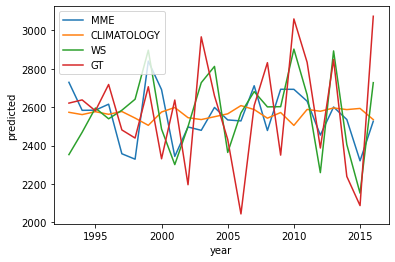

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

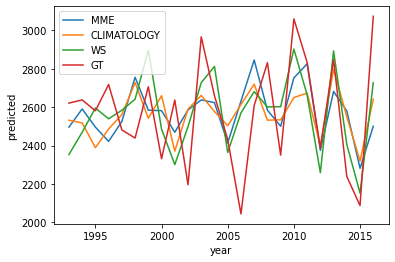

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

<AxesSubplot:xlabel='year', ylabel='predicted'>

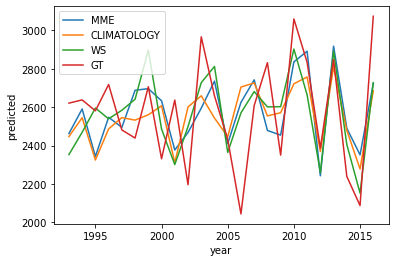

In [544]:
for im in list(range(8,11)):
    res = kfold_cross_validation(kfold_cv_dataset, yield_national, model="MME", init=im)
    sns.lineplot(data=res, x="year", y="predicted", label="MME");
    res = kfold_cross_validation(kfold_cv_dataset, yield_national, model="CLIMATE", init=im)
    sns.lineplot(data=res, x="year", y="predicted", label="CLIMATOLOGY");
    res = kfold_cross_validation(kfold_cv_dataset, yield_national, model="WS", init=im)
    sns.lineplot(data=res, x="year", y="predicted", label="WS");
    sns.lineplot(data=res, x="year", y="yield", label="GT");
    plt.legend(loc = 'upper left');
    plt.show();